# Nucleus Detection

### Next steps

* Work out a loss function
* Decide how to run on other image sizes
* Initialization of weights?
* Normalization of input data

### Mid term plans

* Data augmentation

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [14]:
import data_loaders, prepare_submission, net, mask_prep

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

# Data

In [3]:
train_raw, train_keys_raw = data_loaders.training_images()
# test, test_keys = data_loaders.test_images()

In [4]:
use_saved_weights = True
if use_saved_weights:
    summary_masks_raw, weights_raw = data_loaders.weights()
else: # slow slow slow...
    masks = data_loaders.training_masks()
    summary_masks_raw, weights_raw = mask_prep.weights_from_all_masks(masks)
    print("You probably want to save these weights now")
    data_loaders.save_weights(summary_masks_raw, weights_raw)

In [5]:
# For now, let us reduce our input data to just things that are 256x256
train, train_keys, weights, summary_masks = [], [], [], []
for i in range(len(train_raw)):
    if train_raw[i].shape == (256, 256):
        train.append(train_raw[i])
        train_keys.append(train_keys_raw[i])
        weights.append(weights_raw[i])
        summary_masks.append(summary_masks_raw[i])
print(len(train), len(train_keys), len(weights), len(summary_masks))

334 334 334 334


In [6]:
# Convert from numpy bytes to torch Variable floas
trainV = torch.autograd.Variable(torch.from_numpy(np.array(train).astype(np.float32)))
trainV.unsqueeze_(1)
print(trainV.shape, type(trainV))

# and weights
weightsV = torch.autograd.Variable(
    torch.from_numpy(np.array(weights).astype(np.float32))
)
weightsV.unsqueeze_(1)
print(weightsV.shape, type(weightsV))

# and summary masks
summary_masksV = torch.autograd.Variable(
    torch.from_numpy(np.array(summary_masks).astype(np.float32))
)
summary_masksV.unsqueeze_(1)
print(summary_masksV.shape, type(summary_masksV))

torch.Size([334, 1, 256, 256]) <class 'torch.autograd.variable.Variable'>
torch.Size([334, 1, 256, 256]) <class 'torch.autograd.variable.Variable'>
torch.Size([334, 1, 256, 256]) <class 'torch.autograd.variable.Variable'>


# Exploration

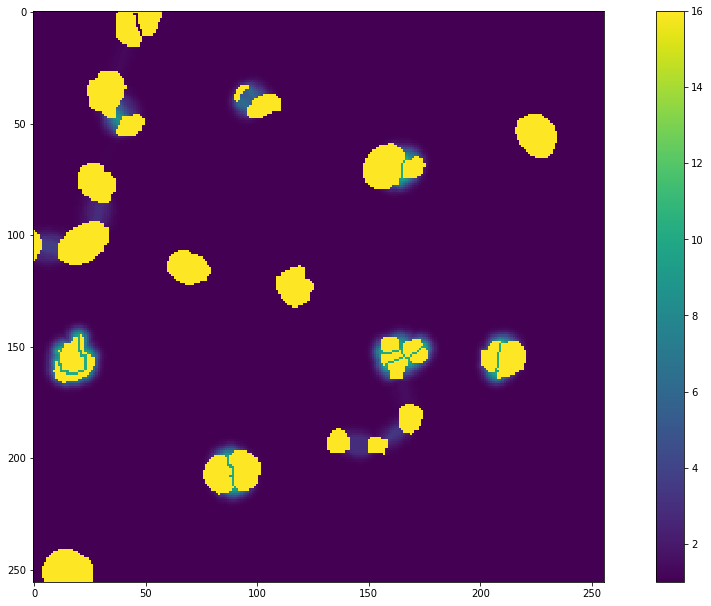

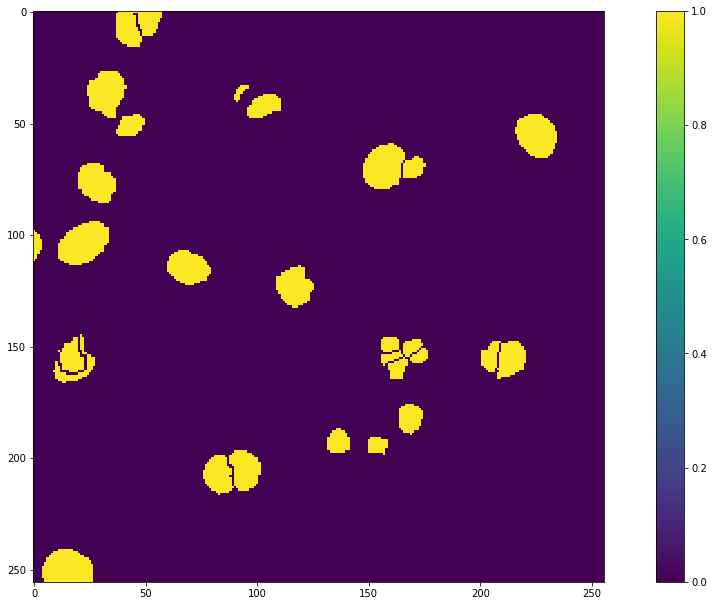

In [33]:
def plot(img):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    img = ax.imshow(img)
    fig.colorbar(img)
for i in [weights, summary_masks]:
    plot(i[3])


# UNET

In [91]:
n = net.u_net().cuda()
optimizer = torch.optim.SGD(n.parameters(), lr=0.0001, momentum=0.9)
batchsize = 1
losses = []

In [96]:

for epoch in range(10):
    t = tqdm(range(len(trainV)), desc="{} Epoch".format(epoch))
    for i in t:
        s = i*batchsize
        # Define input data
        inp = trainV[s:s+batchsize]
        assert inp.shape == (batchsize, 1, 256, 256)
        inp = torch.nn.ReflectionPad2d((348-256)//2)(inp).cuda()
        assert inp.shape == (batchsize, 1, 348, 348)

        # Define expected data and weights
        weight = weightsV[i:i+batchsize].cuda()
        assert weight.shape == (batchsize, 1, 256, 256)
        exp = summary_masksV[i:i+batchsize].cuda()
        assert exp.shape == (batchsize, 1, 256, 256)

        # Ready net
        optimizer.zero_grad()

        # Run net and get output ready for loss and backgrad
        out = n(inp)
        assert out.shape == (batchsize, 1, 260, 260)
        out = out[:,:,2:-2,2:-2]
        assert out.shape == (batchsize, 1, 256, 256)


        # Calculate loss
        
        loss = (weight * (exp - out)**2).mean()
        #loss = torch.nn.functional.mse_loss(out, exp)#, weight)
        #print(loss)
        loss.backward()
        optimizer.step()
        #print("loss:", loss)
        losses.append(loss.data.cpu().numpy()[0])

9 Epoch: 100%|██████████| 334/334 [00:34<00:00,  9.76it/s]


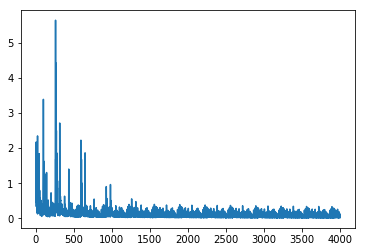

In [97]:
plt.plot(losses)

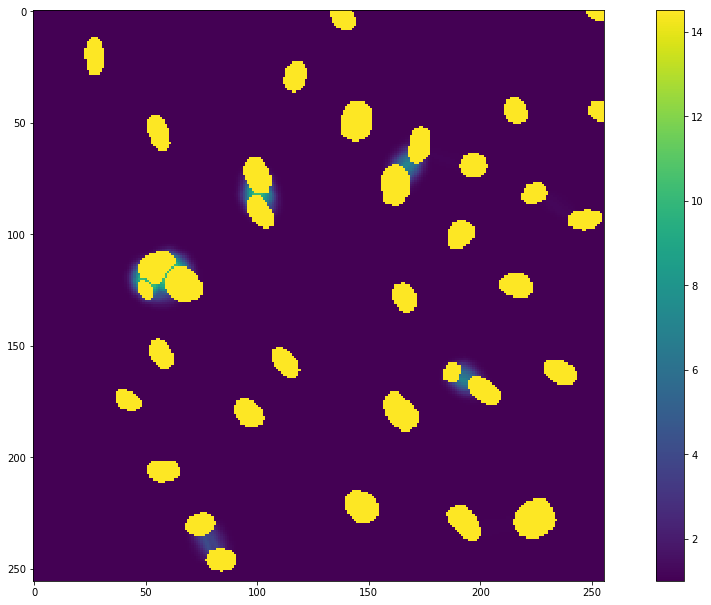

In [72]:
plot(weight[0][0].cpu().data.numpy())

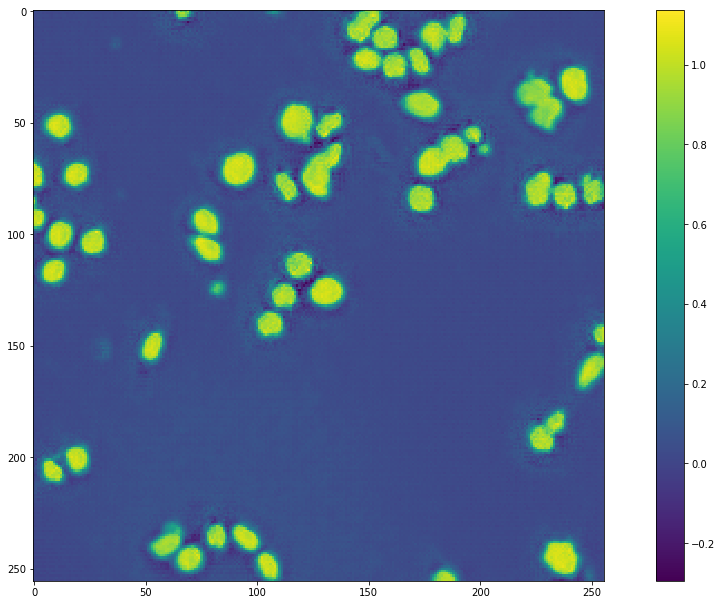

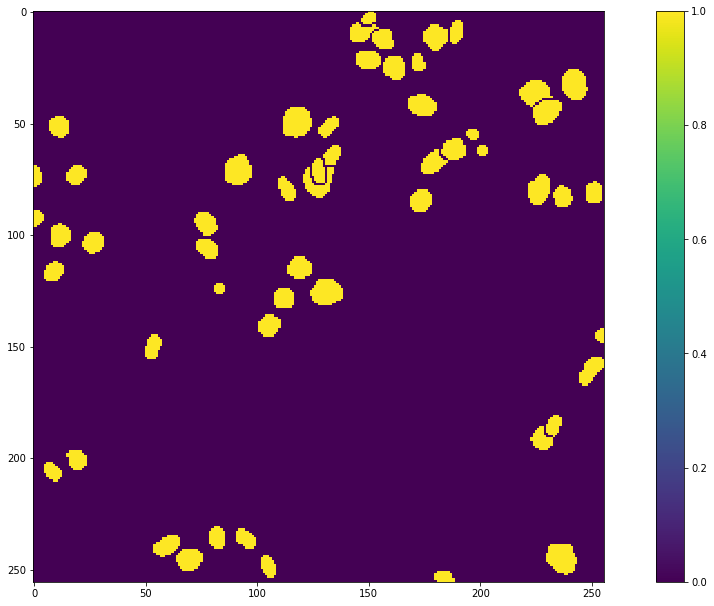

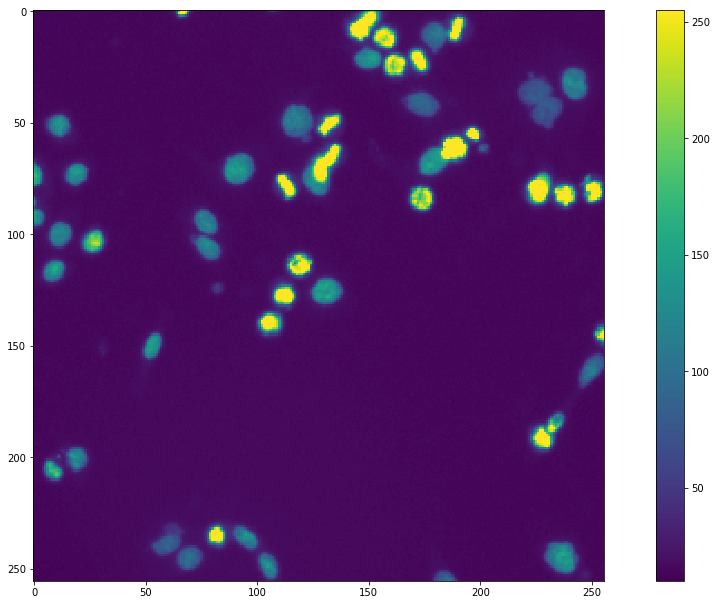

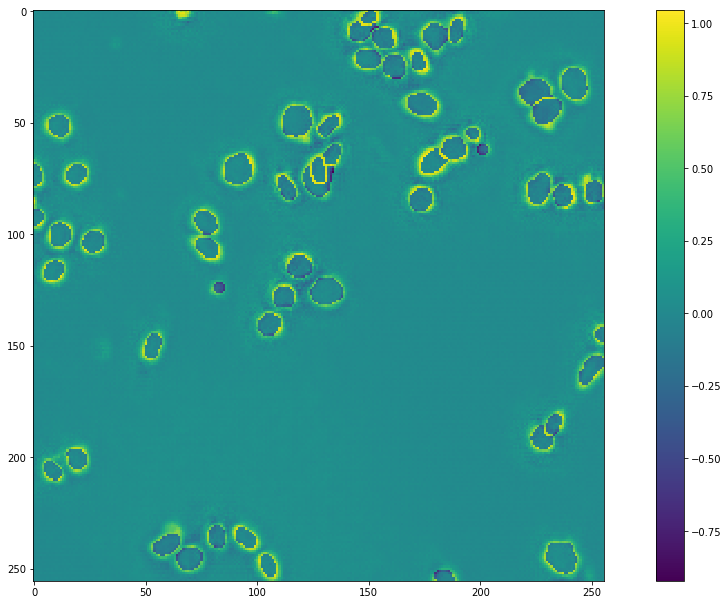

In [98]:
plot(out[0][0].cpu().data.numpy())
plot(exp[0][0].cpu().data.numpy())
plot(inp[0][0][46:-46, 46:-46].cpu().data.numpy())

plot(out[0][0].cpu().data.numpy() - exp[0][0].cpu().data.numpy())
